In [23]:

# Install dependencies 
# pip install opencv-python 
# %pip uninstall mediapipe -v



# Import packages

In [24]:
import mediapipe as mp
import cv2
import numpy as np
import uuid
import os
import copy
import itertools
from collections import deque, Counter
import csv
import tensorflow as tf



# Initials MP Hands

In [25]:
mp_hands = mp.solutions.hands # hands model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

# Detecting Hands Function
A list of 21 hand landmarks on the left hand. Each landmark consists of x, y and z. x and y are normalized to [0.0, 1.0] by the image width and height respectively.

In [26]:
def mediapipe_detection(image, model):
    image = cv2.flip(image, 1)                     # Mirror display
    debug_image = copy.deepcopy(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results ,debug_image

# Drawing Landmarks

In [27]:
def draw_landmarkss(image, hand):
    # Draw Hand connections
    mp_drawing.draw_landmarks(image, hand, mp_hands.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(33, 225, 225), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(33, 225, 225), thickness=2, circle_radius=2),
                             )

In [28]:
def draw_bounding_rect(use_brect, image, brect):
    if use_brect:
        # Outer rectangle
        cv2.rectangle(image, (brect[0], brect[1]), (brect[2], brect[3]),
                     (0, 0, 0), 1)

    return image

In [29]:
def draw_info(image, mode, number):
    if 1 <= mode <= 2:
        cv2.putText(image, "Collecting Data ", (10, 90),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1,
                   cv2.LINE_AA)
        if 0 <= number <= 9:
            cv2.putText(image, "NUM:" + str(number), (10, 110),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (33, 225, 225), 1,
                       cv2.LINE_AA)
    return image


In [30]:
def draw_info_text(image, brect,handedness,finger_gesture_text):
    cv2.rectangle(image, (brect[0], brect[1]), (brect[2], brect[1] - 22),
                 (0, 0, 0), -1)
    
    info_text = handedness.classification[0].label[0:]
        
    if finger_gesture_text != "":
        cv2.putText(image, "Hand Gesture:" + finger_gesture_text, (10, 60),
                   cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 0), 4, cv2.LINE_AA)
        cv2.putText(image, "Hand Gesture:" + finger_gesture_text, (10, 60),
                   cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), 2,
                   cv2.LINE_AA)
        info_text = info_text + ':' + finger_gesture_text
    cv2.putText(image, info_text, (brect[0] + 5, brect[1] - 4),
               cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)

    return image

In [31]:
def draw_point_history(image, point_history):
    for index, point in enumerate(point_history):
        if point[0]!= 0 and point[1] != 0:
            cv2.circle(image, (point[0], point[1]), 1 + int(index / 2),
                      (152, 251, 152), 2)

    return image

# Read labels

In [32]:
actions = ['stop','goLeft', 'goRight', 'modeDiaPo','modeNormal']

# Draw The Rectangle Of Hand

In [33]:
def calc_bounding_rect(image, landmarks):
    image_width, image_height = image.shape[1], image.shape[0]

    landmark_array = np.empty((0, 2), int)

    for _, landmark in enumerate(landmarks.landmark):
        landmark_x = min(int(landmark.x * image_width), image_width - 1) 
        landmark_y = min(int(landmark.y * image_height), image_height - 1)

        landmark_point = [np.array((landmark_x, landmark_y))]

        landmark_array = np.append(landmark_array, landmark_point, axis=0)

    x, y, w, h = cv2.boundingRect(landmark_array)

    return [x, y, x + w, y + h] # retuen the coords of 4 points of the rect

# Extract Keypoint Values of Hand


In [34]:
# def calc_landmark_list(image, landmarks):
#     image_width, image_height = image.shape[1], image.shape[0]

#     landmark_point = []

#     # Keypoint
#     for _, landmark in enumerate(landmarks.landmark):
#         landmark_x = min(int(landmark.x * image_width), image_width - 1)
#         landmark_y = min(int(landmark.y * image_height), image_height - 1)

#         landmark_point.append([landmark_x, landmark_y])

#     return landmark_point # keypoint => [[x1,y1],[x2,y2]]

def calc_landmark_list(image, landmarks):
    image_width, image_height = image.shape[1], image.shape[0]

    landmark_point = []

    # キーポイント
    for _, landmark in enumerate(landmarks.landmark):
        landmark_x = min(int(landmark.x * image_width), image_width - 1)
        landmark_y = min(int(landmark.y * image_height), image_height - 1)
        # landmark_z = landmark.z

        landmark_point.append([landmark_x, landmark_y])

    return landmark_point

# Preprocess Data (Normalisation)

In our case  Coords

In [35]:
# def pre_process_Keypoint_history(image, Keypoints_history):
#     image_width, image_height = image.shape[1], image.shape[0]

#     temporarly_Keypoints_history = copy.deepcopy(Keypoints_history)

#     # Convert to relative coordinates
#     base_x, base_y = 0, 0
#     for index, point in enumerate(temporarly_Keypoints_history):
#         if index == 0:
#             base_x, base_y = point[0], point[1]
#            # point => [x,y]
#          # point => [x,y]

        
#         # Normalization of Coords
#         temporarly_Keypoints_history[index][0] = (temporarly_Keypoints_history[index][0] -
#                                         base_x) / image_width # x / image width
#         temporarly_Keypoints_history[index][1] = (temporarly_Keypoints_history[index][1] -
#                                         base_y) / image_height # y / image height

#     # Convert to a one-dimensional list (Flatten the temporarly_Keypoints_history list to 1d list )
#     temporarly_Keypoints_history = list(
#         itertools.chain.from_iterable(temporarly_Keypoints_history))

#     return temporarly_Keypoints_history

def pre_process_Keypoint_history(image, point_history):
    image_width, image_height = image.shape[1], image.shape[0]

    temp_point_history = copy.deepcopy(point_history)

    base_x, base_y = 0, 0
    for index, point in enumerate(temp_point_history):
        if index == 0:
            base_x, base_y = point[0], point[1]

        temp_point_history[index][0] = (temp_point_history[index][0] -
                                        base_x) / image_width
        temp_point_history[index][1] = (temp_point_history[index][1] -
                                        base_y) / image_height

    temp_point_history = list(
        itertools.chain.from_iterable(temp_point_history))

    return temp_point_history


In [36]:
def pre_process_landmark(landmark_list):
    temporarly_landmark_list = copy.deepcopy(landmark_list)

    # Convert to relative coordinates
    base_x, base_y = 0, 0
    for index, landmark_point in enumerate(temporarly_landmark_list):
        if index == 0:
            base_x, base_y = landmark_point[0], landmark_point[1]

        temporarly_landmark_list[index][0] = temporarly_landmark_list[index][0] - base_x
        temporarly_landmark_list[index][1] = temporarly_landmark_list[index][1] - base_y

    # Convert to a one-dimensional list
    temporarly_landmark_list = list(
        itertools.chain.from_iterable(temporarly_landmark_list))

    # Normalization
    max_value = max(list(map(abs, temporarly_landmark_list)))

    def normalize_(n):
        return n / max_value

    temporarly_landmark_list = list(map(normalize_, temporarly_landmark_list))

    return temporarly_landmark_list

# Save Collected Coords

In [37]:
def logging_csv(number, mode, point_history_list):
    if mode == 0:
        pass
    if mode == 2 and (0 <= number <= 9):
        csv_path = 'Gestures_Presentation_Controle_DataSet/KeyPoints.csv'
        with open(csv_path, 'a', newline="") as f:
            writer = csv.writer(f)
            writer.writerow([number, *point_history_list])
    return

# Choise of Mode

In [38]:
def select_mode(key, mode):
    number = -1
    if 48 <= key <= 57:  # 0 ~ 9
        number = key - 48
    if key == 110:  # n normal
        mode = 0
    if key == 104:  # h trainig frame
        mode = 2
    return number, mode

In [39]:
def draw_landmarks(image, landmark_point):
    # 接続線
    if len(landmark_point) > 0:
        # 親指
        cv2.line(image, tuple(landmark_point[2]), tuple(landmark_point[3]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[2]), tuple(landmark_point[3]),
                (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[3]), tuple(landmark_point[4]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[3]), tuple(landmark_point[4]),
                (255, 255, 255), 2)

        # 人差指
        cv2.line(image, tuple(landmark_point[5]), tuple(landmark_point[6]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[5]), tuple(landmark_point[6]),
                (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[6]), tuple(landmark_point[7]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[6]), tuple(landmark_point[7]),
                (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[7]), tuple(landmark_point[8]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[7]), tuple(landmark_point[8]),
                (255, 255, 255), 2)

        # 中指
        cv2.line(image, tuple(landmark_point[9]), tuple(landmark_point[10]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[9]), tuple(landmark_point[10]),
                (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[10]), tuple(landmark_point[11]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[10]), tuple(landmark_point[11]),
                (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[11]), tuple(landmark_point[12]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[11]), tuple(landmark_point[12]),
                (255, 255, 255), 2)

        # 薬指
        cv2.line(image, tuple(landmark_point[13]), tuple(landmark_point[14]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[13]), tuple(landmark_point[14]),
                (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[14]), tuple(landmark_point[15]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[14]), tuple(landmark_point[15]),
                (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[15]), tuple(landmark_point[16]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[15]), tuple(landmark_point[16]),
                (255, 255, 255), 2)

        # 小指
        cv2.line(image, tuple(landmark_point[17]), tuple(landmark_point[18]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[17]), tuple(landmark_point[18]),
                (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[18]), tuple(landmark_point[19]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[18]), tuple(landmark_point[19]),
                (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[19]), tuple(landmark_point[20]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[19]), tuple(landmark_point[20]),
                (255, 255, 255), 2)

        # 手の平
        cv2.line(image, tuple(landmark_point[0]), tuple(landmark_point[1]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[0]), tuple(landmark_point[1]),
                (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[1]), tuple(landmark_point[2]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[1]), tuple(landmark_point[2]),
                (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[2]), tuple(landmark_point[5]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[2]), tuple(landmark_point[5]),
                (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[5]), tuple(landmark_point[9]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[5]), tuple(landmark_point[9]),
                (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[9]), tuple(landmark_point[13]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[9]), tuple(landmark_point[13]),
                (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[13]), tuple(landmark_point[17]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[13]), tuple(landmark_point[17]),
                (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[17]), tuple(landmark_point[0]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[17]), tuple(landmark_point[0]),
                (255, 255, 255), 2)

    # キーポイント
    for index, landmark in enumerate(landmark_point):
        if index == 0:  # 手首1
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 1:  # 手首2
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 2:  # 親指：付け根
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 3:  # 親指：第1関節
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 4:  # 親指：指先
            cv2.circle(image, (landmark[0], landmark[1]), 8, (255, 255, 255),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 8, (0, 0, 0), 1)
        if index == 5:  # 人差指：付け根
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 6:  # 人差指：第2関節
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 7:  # 人差指：第1関節
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 8:  # 人差指：指先
            cv2.circle(image, (landmark[0], landmark[1]), 8, (255, 255, 255),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 8, (0, 0, 0), 1)
        if index == 9:  # 中指：付け根
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 10:  # 中指：第2関節
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 11:  # 中指：第1関節
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 12:  # 中指：指先
            cv2.circle(image, (landmark[0], landmark[1]), 8, (255, 255, 255),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 8, (0, 0, 0), 1)
        if index == 13:  # 薬指：付け根
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 14:  # 薬指：第2関節
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 15:  # 薬指：第1関節
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 16:  # 薬指：指先
            cv2.circle(image, (landmark[0], landmark[1]), 8, (255, 255, 255),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 8, (0, 0, 0), 1)
        if index == 17:  # 小指：付け根
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 18:  # 小指：第2関節
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 19:  # 小指：第1関節
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 20:  # 小指：指先
            cv2.circle(image, (landmark[0], landmark[1]), 8, (255, 255, 255),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 8, (0, 0, 0), 1)

    return image

# Classifier

In [40]:
class Classifier(object):
    def __init__(
        self,
        model_path='Model/Gestures_classifier.tflite',
        score_th=0.5,
        invalid_value=0,
        num_threads=1,
    ):
        self.interpreter = tf.lite.Interpreter(model_path=model_path,
                                               num_threads=num_threads)

        self.interpreter.allocate_tensors()
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()

        self.score_th = score_th
        self.invalid_value = invalid_value

    def __call__(
        self,
        point_history,
    ):
        input_details_tensor_index = self.input_details[0]['index']
        self.interpreter.set_tensor(
            input_details_tensor_index,
            np.array([point_history], dtype=np.float32))
        self.interpreter.invoke()

        output_details_tensor_index = self.output_details[0]['index']

        result = self.interpreter.get_tensor(output_details_tensor_index)

        result_index = np.argmax(np.squeeze(result))

        if np.squeeze(result)[result_index] < self.score_th:
            result_index = self.invalid_value

        return result_index



keypoint_classifier = Classifier()



In [41]:
from keras.models import load_model
model_save_path = 'Model/Gestures_classifier.h5'


def classifier_h5(pre_processed_Keypoints_list):
    model = load_model(model_save_path)
    predict_result = model.predict(np.expand_dims(pre_processed_Keypoints_list, axis=0))
    result_index = np.argmax(np.squeeze(predict_result))
    return result_index




In [42]:
# Parameters Initialisation 
history_length = 16 # lenght of list that takes max indexes of predections 
Keypoints_history = deque(maxlen=history_length)
Argmax_list = deque(maxlen=history_length)
mode = 0 #mode Normal 
use_boundary_recttangle = True

In [45]:
# Camera preparation
cap = cv2.VideoCapture(1)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 960)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 540)

# Set mediapipe model 
with mp_hands.Hands(min_detection_confidence=0.7, min_tracking_confidence=0.5,max_num_hands=1) as hands: 

    while cap.isOpened():

       # Process Key (ESC: end) 
       key = cv2.waitKey(10)
       if key == 27:  # ESC
          break
       # number, mode = select_mode(key, mode)

       # Camera capture #####################################################
       ret, frame = cap.read()
       if not ret:
          break

       # Make detections
       image, results, debug_image = mediapipe_detection(frame, hands)

       if results.multi_hand_landmarks:
            for hand_landmarks, handedness in zip(results.multi_hand_landmarks,
                                                  results.multi_handedness):
                
                # Bounding box calculation
                brect = calc_bounding_rect(debug_image, hand_landmarks)

                # Landmark calculation
                landmark_list = calc_landmark_list(debug_image, hand_landmarks)
                
                # Conversion to relative coordinates / normalized coordinates
                pre_processed_Keypoints_list = pre_process_Keypoint_history(
                    debug_image, Keypoints_history)
                print(pre_processed_Keypoints_list)
                print(len(pre_processed_Keypoints_list))
                
                Keypoints_history.append(landmark_list[12])
                
                hand_sign_id=0
              
                hand_sign_len = len(pre_processed_Keypoints_list)
                
                if hand_sign_len == (history_length * 2):
                    hand_sign_id = keypoint_classifier(pre_processed_Keypoints_list)

                Argmax_list.append(hand_sign_id)
                most_common_fg_id = Counter(
                    Argmax_list).most_common()
                
                # Drawing part
                debug_image = draw_bounding_rect(use_boundary_recttangle, debug_image, brect)
                debug_image = draw_landmarks(debug_image, landmark_list)
                debug_image = draw_info_text(
                    debug_image,
                    brect,
                    handedness,
                    actions[most_common_fg_id[0][0]],
                )
       else:
           Keypoints_history.append([0, 0])


       # debug_image = draw_info(debug_image, mode, number)
       debug_image = draw_point_history(debug_image, Keypoints_history)



       # Screen reflection 
       cv2.imshow('Hand Gesture Recognition', debug_image)


cap.release()

cv2.destroyAllWindows()

        

[0.0, 0.0, 0.003125, -0.0020833333333333333, 0.00625, -0.0020833333333333333, 0.0046875, -0.00625, -0.00625, 0.020833333333333332, -0.0125, 0.027083333333333334, -0.0171875, 0.03333333333333333, -0.01875, 0.035416666666666666, -0.0203125, 0.035416666666666666, -0.025, 0.04791666666666667, -0.0265625, 0.05, -0.0265625, 0.05, -0.0234375, 0.04791666666666667, -0.021875, 0.05, -0.0171875, 0.052083333333333336, -0.0125, 0.058333333333333334]
32
[0.0, 0.0, 0.003125, 0.0, 0.0015625, -0.004166666666666667, -0.009375, 0.022916666666666665, -0.015625, 0.029166666666666667, -0.0203125, 0.035416666666666666, -0.021875, 0.0375, -0.0234375, 0.0375, -0.028125, 0.05, -0.0296875, 0.052083333333333336, -0.0296875, 0.052083333333333336, -0.0265625, 0.05, -0.025, 0.052083333333333336, -0.0203125, 0.05416666666666667, -0.015625, 0.06041666666666667, -0.6234375, 0.29375]
32
[0.0, 0.0, -0.0015625, -0.004166666666666667, -0.0125, 0.022916666666666665, -0.01875, 0.029166666666666667, -0.0234375, 0.035416666666

# **Build and Train The Model**

**import necessary package**

In [ ]:
%pip install  scikit-learn 

In [8]:
from sklearn.model_selection import train_test_split
import numpy as np

**input shape**

In [5]:
TIME_STEPS = 16
DIMENSION = 2

**Load DataSet and  Features & lables**

In [6]:
dataset = 'Gestures_Presentation_Controle_DataSet/KeyPoints.csv'
model_save_path = 'Gestures_classifier.h5'
Logs = 'C:/oussamaboussaid/Hand_Gestures_Detection_and_Recognition_Project/Logs'

In [9]:
X_features  = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1)))
Y_lables  = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

# split features ana lables into train and test
RANDOM_SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X_features, Y_lables, train_size=0.75, random_state=RANDOM_SEED)

In [12]:
X_train.shape

(1821, 32)

**Define a Callback to use for EarlyStopping**

In [ ]:
%pip install tensorflow

In [13]:
from tensorflow.keras.callbacks import TensorBoard

log_dir = os.path.join('C:/oussamaboussaid/Hand_Gestures_Detection_and_Recognition_Project/Logs')
cp_callback = TensorBoard(log_dir=log_dir)

# callback for earlyStopping
Earlystopping_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

ImportError: cannot import name 'builder' from 'google.protobuf.internal' (C:\Users\Kibbou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\google\protobuf\internal\__init__.py)

In [28]:
%tensorboard -- logdir={log_folder}

UsageError: Line magic function `%tensorboard` not found.


**Build The Model**

In [44]:
# Modl Param
use_lstm = False
NUM_CLASSES = 5

In [45]:
if use_lstm:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION, )), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(16, input_shape=[TIME_STEPS, DIMENSION]),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

In [46]:
model.compile( optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'] )

**Train The Model**

In [47]:
model.fit( X_train, y_train, epochs=1000, batch_size=128, validation_data=(X_test, y_test), callbacks=[cp_callback, Earlystopping_callback] )

Epoch 1/1000
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 1/15 [=>............................] - ETA: 19s - loss: 1.6064 - accuracy: 0.3281Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\Kibbou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Kibbou\AppData\Local\Temp\ipykernel_21028\4189529025.py", line 1, in <module>
    model.fit( X_train, y_train, epochs=1000, batch_size=128, validation_data=(X_test, y_test), callbacks=[cp_callback, Earlystopping_callback] )
  File "C:\Users\Kibbou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
  File "C:\Users\Kibbou\AppData\Local\Temp\__autograph_generated_filepb5vncrb.py", line 29, in tf__predict_function
    ag__.for_stmt(ag__.converted_call(ag__.ld(tf).range, (ag__.ld(self)._steps_per_execution - 1,), None, fscope), None, loop_body, get_state, se

: 

**Model Summary**

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 24)                792       
                                                                 
 dropout_1 (Dropout)         (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                250       
                                                                 
 dense_2 (Dense)             (None, 5)                 55        
                                                                 
Total params: 1,097
Trainable params: 1,097
Non-trainable params: 0
_________________________________________________________________


**Save Weights**


In [34]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=100)

7/7 [==============================] - 0s 1ms/step - loss: 0.1826 - accuracy: 0.9589


In [35]:
model.save(model_save_path, include_optimizer=False)

**Test the model ( Make Predictions )**

In [35]:
from keras.models import load_model
model = load_model(model_save_path)

In [36]:
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))
print(actions[np.argmax(np.squeeze(predict_result))])


NameError: name 'X_test' is not defined

Evaluate The Model

Confusion matrix

In [38]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


19/19 [==============================] - 0s 889us/step


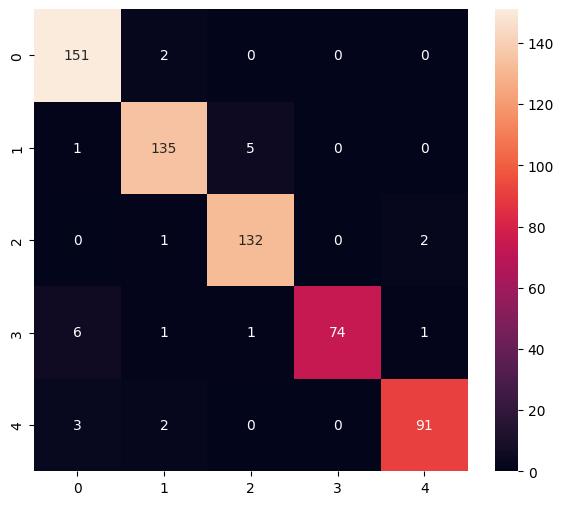

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       153
           1       0.96      0.96      0.96       141
           2       0.96      0.98      0.97       135
           3       1.00      0.89      0.94        83
           4       0.97      0.95      0.96        96

    accuracy                           0.96       608
   macro avg       0.96      0.95      0.96       608
weighted avg       0.96      0.96      0.96       608



In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite


**Save as a model dedicated to inference**


In [40]:
model = tf.keras.models.load_model(model_save_path)

In [23]:
tflite_save_path = 'Gestures_classifier.tflite'

**Transform model (quantization)**

In [42]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Kibbou\AppData\Local\Temp\tmpts5l81nm\assets


6476

**Inference test**

In [24]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [25]:
# get input/output tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([ 1, 32]), 'shape_signature': array([-1, 32]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [67]:
X_test[0]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.0015625 ,
       -0.00208333,  0.0015625 , -0.00208333,  0.0015625 , -0.00208333,
        0.0015625 ,  0.        ,  0.0015625 ,  0.        ,  0.        ,
        0.00833333, -0.003125  ,  0.02291667, -0.0015625 ,  0.02291667,
       -0.0078125 ,  0.04791667, -0.00625   ,  0.05      , -0.0109375 ,
        0.08125   , -0.021875  ,  0.12708333, -0.0296875 ,  0.17083333,
       -0.028125  ,  0.17708333], dtype=float32)

In [64]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [65]:
%%time
# Inference implementation
interpreter.invoke()           
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 999 µs


In [66]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[9.6668848e-14 8.7255967e-06 2.0683417e-03 9.1446523e-04 9.9700838e-01]
4
